In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from datetime import datetime
from pandas import get_dummies
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

In [2]:
data = pd.read_csv("Churn_Modelling.csv")
print("There are {} rows & {} columns in data-set.".format(data.shape[0], data.shape[1]))
data.head()

There are 10000 rows & 14 columns in data-set.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Here in **Exited** column **1** represents that the customer will **leave the bank** & **0** represents that he/she will **stay in bank.**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


So, we have no **missing values** in our data-set.

In [4]:
data[data.isnull().any(axis=1)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


# Exploratory Data Analysis :-

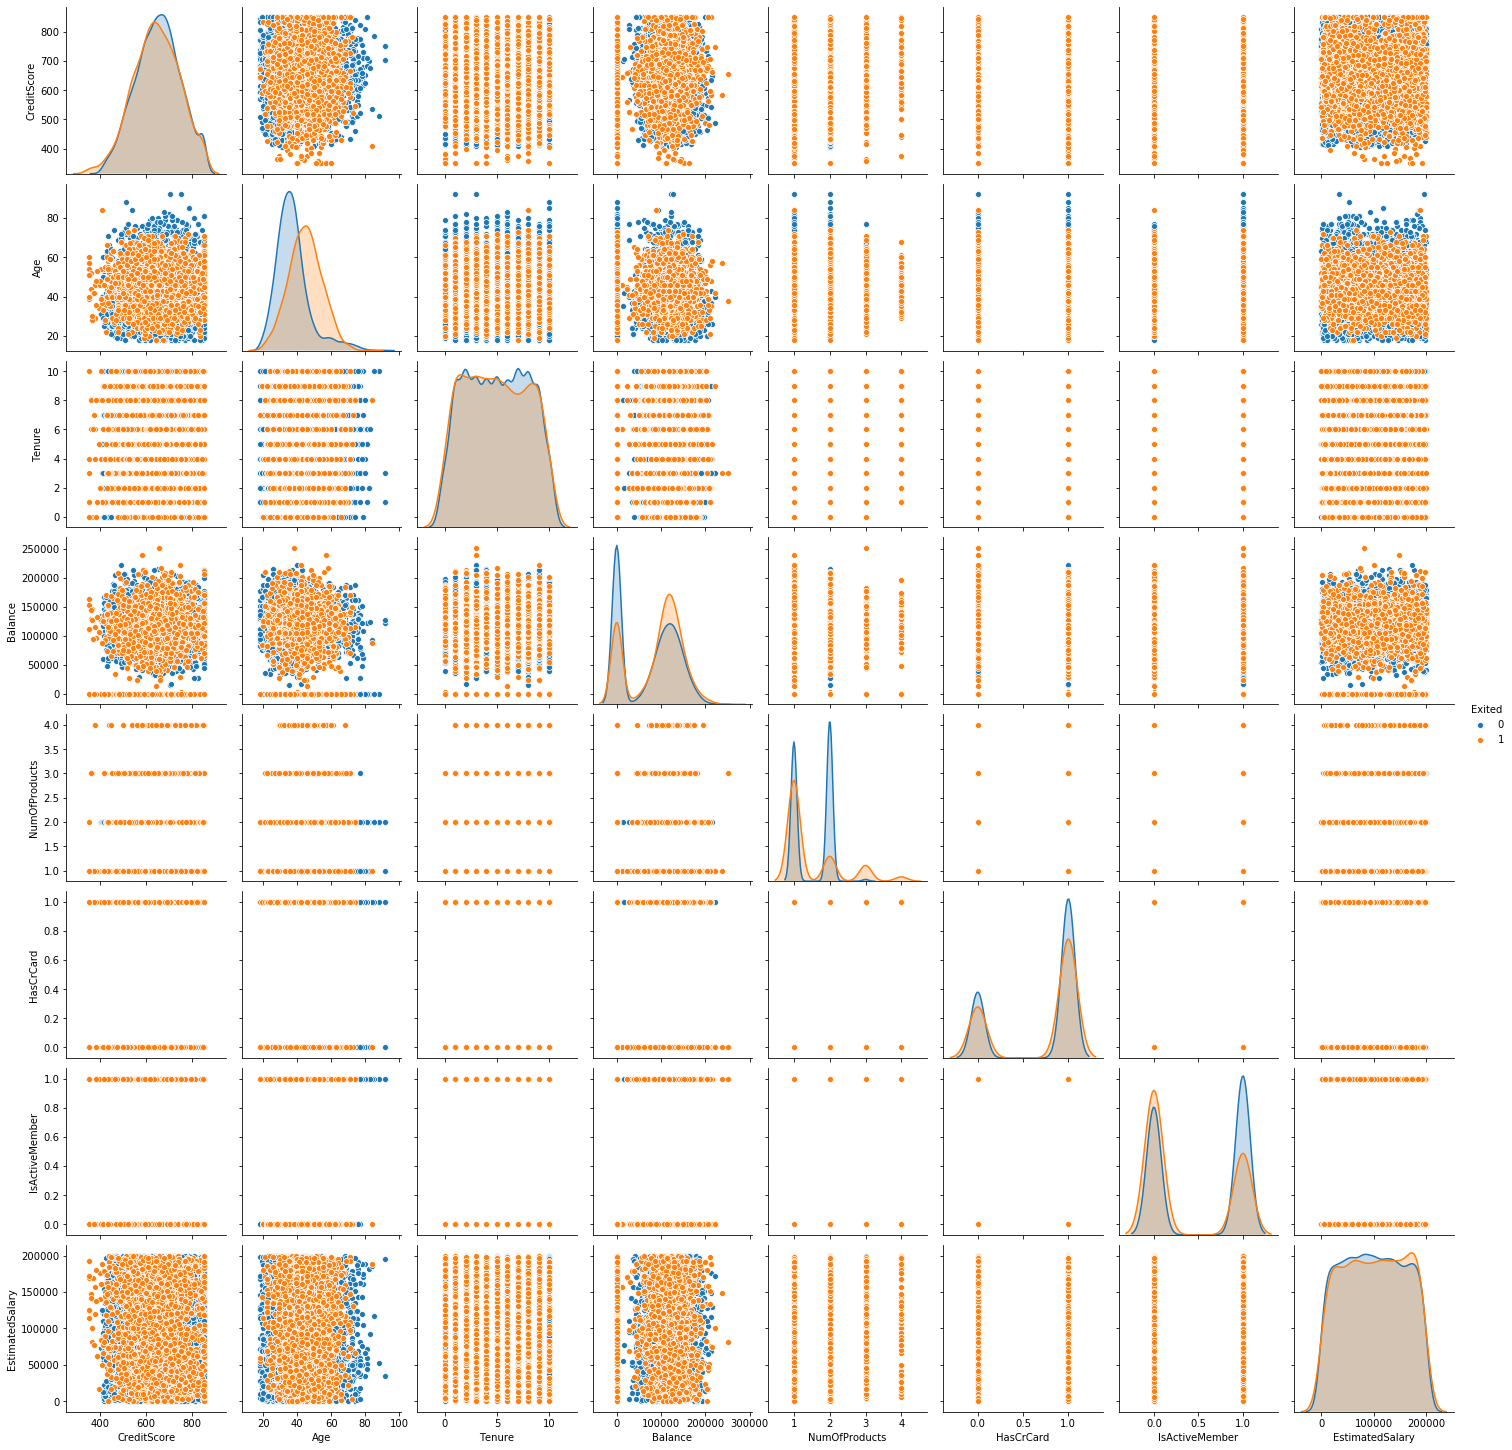

In [5]:
pairplot_data = data.drop(["RowNumber", "CustomerId", "Surname", "Geography", "Gender"], axis=1)
sns.pairplot(pairplot_data, hue="Exited")

# Data Cleaning :-

As we don't have any use of CustomerId, RowNumber & Surname.

In [6]:
cleaned_data = data.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
cleaned_data.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [7]:
cleaned_data.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [8]:
cleaned_data.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

# Data Pre-processing :-

Now it's time for some **pre-processing** on **Gender & Geography Columns :-**

Here we will be using One-Hot-Encoding as we are having nomial categorical features and that too with limited categories.

In [9]:
geography = get_dummies(cleaned_data.Geography).drop("Spain", axis=1)
geography.head(3)

,France,Germany
0,1,0
1,0,0
2,1,0


In [10]:
cleaned_data = cleaned_data.join(geography)
cleaned_data.Gender = get_dummies(cleaned_data.Gender).drop("Male", axis=1)
final_data = cleaned_data.drop("Geography", axis=1)
final_data.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0
5,645,0,44,8,113755.78,2,1,0,149756.71,1,0,0
6,822,0,50,7,0.00,2,1,1,10062.80,0,1,0
7,376,1,29,4,115046.74,4,1,0,119346.88,1,0,1
8,501,0,44,4,142051.07,2,0,1,74940.50,0,1,0
9,684,0,27,2,134603.88,1,1,1,71725.73,0,1,0


In [11]:
# # We can use this way as well to convert our categories into numerical values, if we have low number of categories.
# gender_dict = {"Female":1,
#               "Male":0}
# cleaned_data.Gender = cleaned_data.Gender.map(gender_dict)
# cleaned_data.Gender

# Splitting The Data :-

In [12]:
y = final_data["Exited"]
X = final_data.drop("Exited", axis=1)

X_tr, X_test, y_tr, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr)


print("There are {} rows & {} columns in X_train".format(X_train.shape[0], X_train.shape[1]))
print("There are {} rows & {} columns in X_test".format(X_test.shape[0], X_test.shape[1]))
print("There are {} rows & {} columns in X_cv".format(X_cv.shape[0], X_cv.shape[1]))

for i in range(1):
    print("Length of y_train :- ", y_train.shape[i])
    print("Length of y_test :- ", y_test.shape[i])
    print("Length of y_cv :- ", y_cv.shape[i])

There are 6400 rows & 11 columns in X_train
There are 2000 rows & 11 columns in X_test
There are 1600 rows & 11 columns in X_cv
Length of y_train :-  6400
Length of y_test :-  2000
Length of y_cv :-  1600


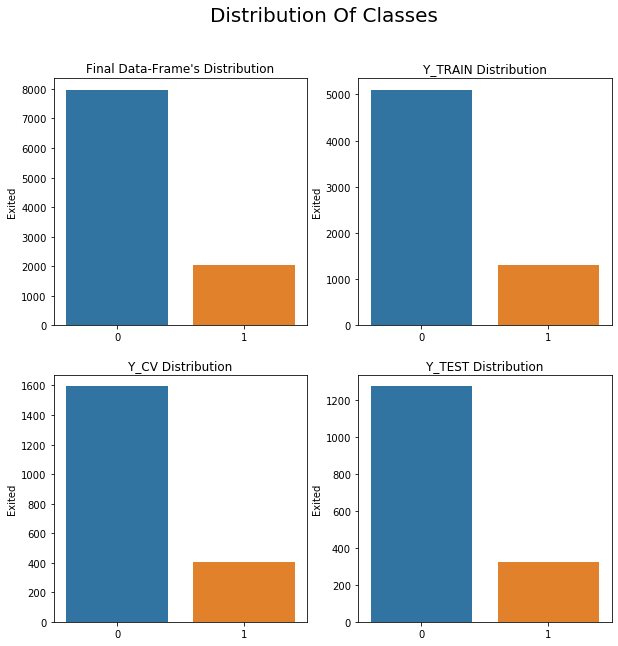

In [13]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
sns.barplot(x=final_data["Exited"].value_counts().index, y=final_data["Exited"].value_counts(), ax=axes[0,0]).set_title("Final Data-Frame's Distribution")
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(), ax=axes[0,1]).set_title("Y_TRAIN Distribution")
sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(), ax=axes[1,0]).set_title("Y_CV Distribution")
sns.barplot(x=y_cv.value_counts().index, y=y_cv.value_counts(), ax=axes[1,1]).set_title("Y_TEST Distribution")
plt.suptitle("Distribution Of Classes", fontsize=20)
plt.show()

# Creating 1st Model :-

In [14]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [15]:
cv_pred_xgb = xgb.predict(X_cv)
test_pred_xgb = xgb.predict(X_test)

In [16]:
print("Accuracy Of CV :- ", accuracy_score(y_cv, cv_pred_xgb)*100)
print("Accuracy Of Test :- ", accuracy_score(y_test, test_pred_xgb)*100)

Accuracy Of CV :-  85.625
Accuracy Of Test :-  84.7


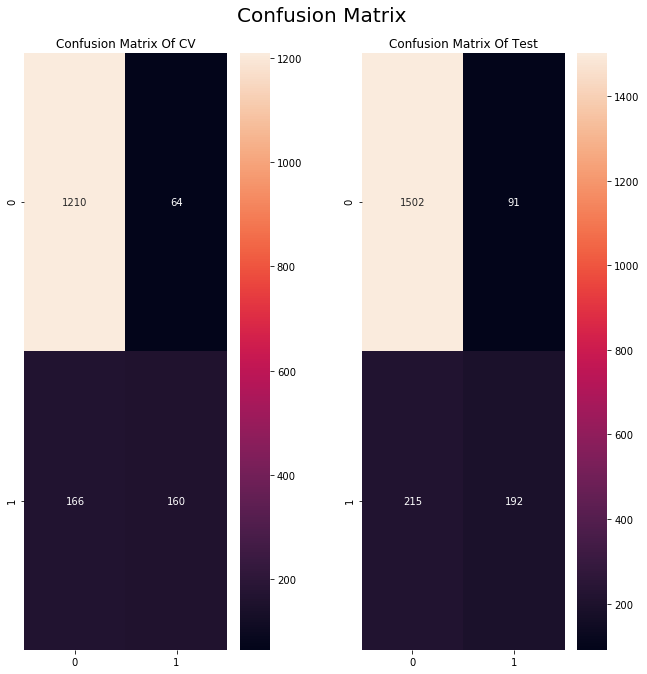

In [17]:
cv_conf_xgb = confusion_matrix(y_cv, cv_pred_xgb)
test_conf_xgb = confusion_matrix(y_test, test_pred_xgb)

fig, axes = plt.subplots(1,2,figsize=(10,10))
sns.heatmap(cv_conf_xgb, annot=True, fmt="d", ax=axes[0]).set_title("Confusion Matrix Of CV")
sns.heatmap(test_conf_xgb, annot=True, fmt="d", ax=axes[1]).set_title("Confusion Matrix Of Test")
plt.suptitle("Confusion Matrix", fontsize=20)
plt.tight_layout(pad=4.5)
plt.show()

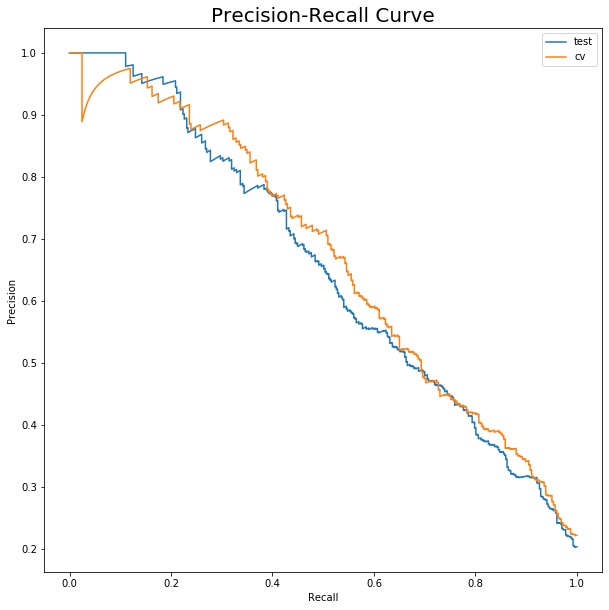

In [18]:
prepro_test_xgb = xgb.predict_proba(X_test)[:,1]
prepro_cv_xgb = xgb.predict_proba(X_cv)[:,1]

precision_xgb, recall_xgb, threshold_2_xgb = precision_recall_curve(y_test, prepro_test_xgb)
precision_1_xgb, recall_1_xgb, threshold_3_xgb = precision_recall_curve(y_cv, prepro_cv_xgb)

fig_1 = plt.figure(figsize=(10,10))
ax_1 = plt.subplot(111)
ax_1.plot(recall_xgb,precision_xgb, label="test")
ax_1.plot(recall_1_xgb,precision_1_xgb, label="cv")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

# Let's Try RandomizedSearchCv for Hyperparameter Optimization :-

In [19]:
# params={
#  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
# }

In [20]:
# # A function to calculate the time of the following hyperparameter techniques to complete process :-

# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [21]:
"""This process took 25.36 seconds to complete in my system and gave these as best parameters :-
{'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.4}."""

# random_search_cv = RandomizedSearchCV(estimator=xgb, param_distributions=params, scoring="roc_auc", n_jobs=-1, cv=5, verbose=3)

# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search_cv.fit(X_train, y_train)
# timer(start_time) # timing ends here for "start_time" variable

"This process took 25.36 seconds to complete in my system and gave these as best parameters :-\n{'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.4}."

In [22]:
# random_search_cv.best_estimator_

In [23]:
# random_search_cv.best_params_

In [24]:
# random_search_cv.best_score_*100

**Let's create it's model :-**

In [25]:
xgb_rscv = xgboost.XGBClassifier(min_child_weight=7, max_depth=4, learning_rate=0.05, gamma=0.0, colsample_bytree=0.4)
xgb_rscv.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [26]:
cv_pred_xgb_rscv = xgb_rscv.predict(X_cv)
test_pred_xgb_rscv = xgb_rscv.predict(X_test)
print("Accuracy Of CV :- ", accuracy_score(y_cv, cv_pred_xgb_rscv)*100)
print("Accuracy Of Test :- ", accuracy_score(y_test, test_pred_xgb_rscv)*100)

Accuracy Of CV :-  85.625
Accuracy Of Test :-  86.2


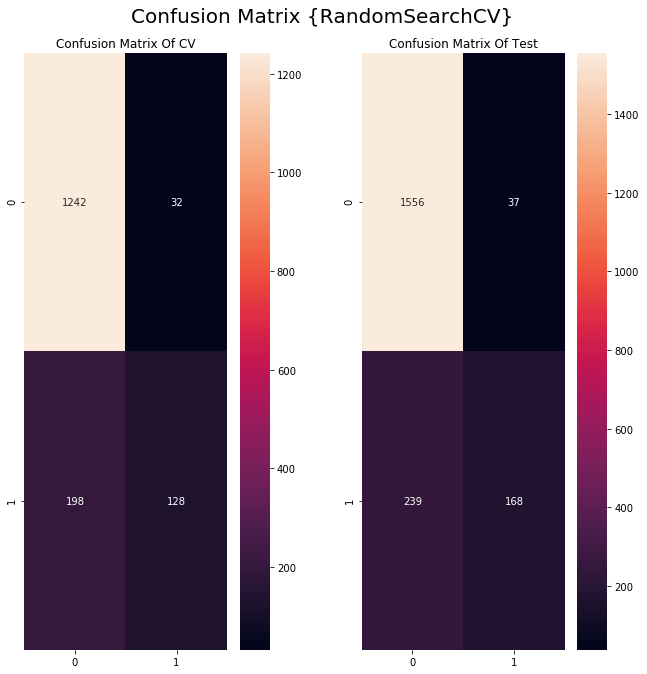

In [27]:
cv_conf_xgb_rscv = confusion_matrix(y_cv, cv_pred_xgb_rscv)
test_conf_xgb_rscv = confusion_matrix(y_test, test_pred_xgb_rscv)

fig, axes = plt.subplots(1,2,figsize=(10,10))
sns.heatmap(cv_conf_xgb_rscv, annot=True, fmt="d", ax=axes[0]).set_title("Confusion Matrix Of CV")
sns.heatmap(test_conf_xgb_rscv, annot=True, fmt="d", ax=axes[1]).set_title("Confusion Matrix Of Test")
plt.suptitle("Confusion Matrix {RandomSearchCV}", fontsize=20)
plt.tight_layout(pad=4.5)
plt.show()

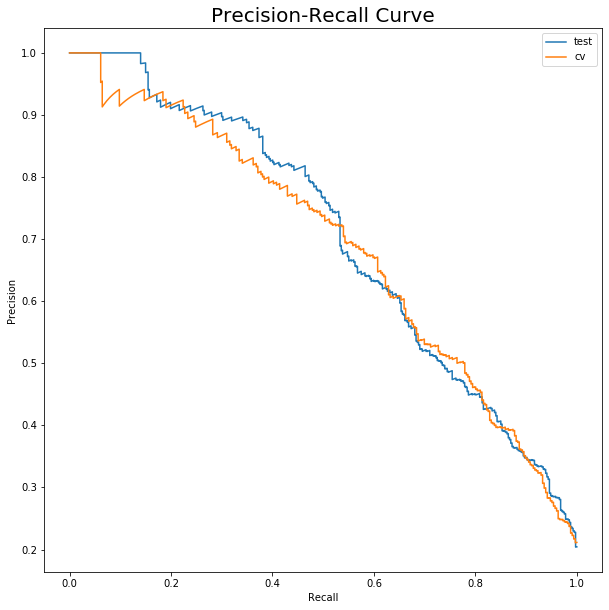

In [28]:
prepro_test_xgb_rscv = xgb_rscv.predict_proba(X_test)[:,1]
prepro_cv_xgb_rscv = xgb_rscv.predict_proba(X_cv)[:,1]

precision_xgb_rscv, recall_xgb_rscv, threshold_2_xgb_rscv = precision_recall_curve(y_test, prepro_test_xgb_rscv)
precision_1_xgb_rscv, recall_1_xgb_rscv, threshold_3_xgb_rscv = precision_recall_curve(y_cv, prepro_cv_xgb_rscv)

fig_1 = plt.figure(figsize=(10,10))
ax_1 = plt.subplot(111)
ax_1.plot(recall_xgb_rscv,precision_xgb_rscv, label="test")
ax_1.plot(recall_1_xgb_rscv,precision_1_xgb_rscv, label="cv")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

# Let's Try GridSearchCv for Hyperparameter Optimization :-

In [29]:
# params={
#  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
# }

In [30]:
"""This process took 61 minutes to complete in my system and gave these as best parameters :-
{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1}."""

# grid_search_cv = GridSearchCV(estimator=xgb, param_grid=params, scoring="accuracy", verbose=3)

# start_time = timer(None) # timing starts from this point for "start_time" variable
# grid_search_cv.fit(X_train, y_train)
# timer(start_time) # timing ends here for "start_time" variable

"This process took 61 minutes to complete in my system and gave these as best parameters :-\n{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1}."

In [31]:
# grid_search_cv.best_estimator_

In [32]:
# grid_search_cv.best_params_

In [33]:
# grid_search_cv.best_score_

**Let's build it's model :-**

In [34]:
xgb_gscv = xgboost.XGBClassifier(gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1)
xgb_gscv.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [35]:
cv_pred_xgb_gscv = xgb_gscv.predict(X_cv)
test_pred_xgb_gscv = xgb_gscv.predict(X_test)
print("Accuracy Of CV :- ", accuracy_score(y_cv, cv_pred_xgb_gscv)*100)
print("Accuracy Of Test :- ", accuracy_score(y_test, test_pred_xgb_gscv)*100)

Accuracy Of CV :-  86.125
Accuracy Of Test :-  86.9


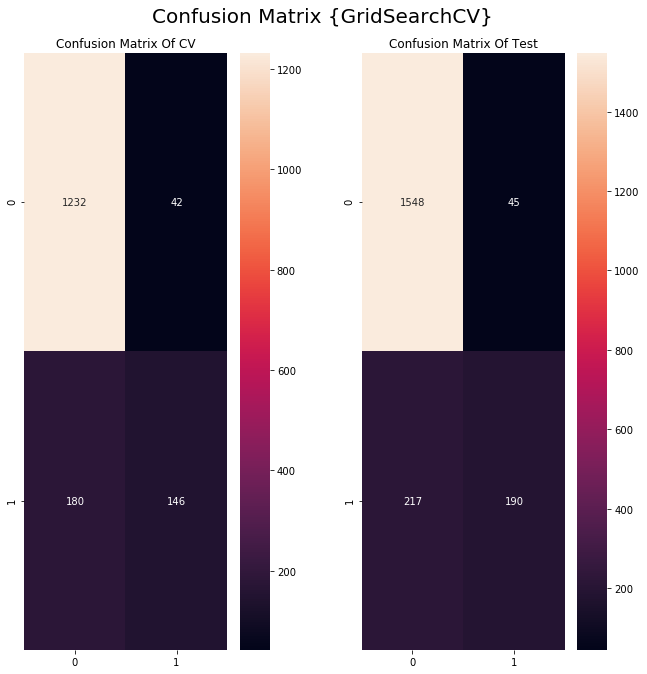

In [36]:
cv_conf_xgb_gscv = confusion_matrix(y_cv, cv_pred_xgb_gscv)
test_conf_xgb_gscv = confusion_matrix(y_test, test_pred_xgb_gscv)

fig, axes = plt.subplots(1,2,figsize=(10,10))
sns.heatmap(cv_conf_xgb_gscv, annot=True, fmt="d", ax=axes[0]).set_title("Confusion Matrix Of CV")
sns.heatmap(test_conf_xgb_gscv, annot=True, fmt="d", ax=axes[1]).set_title("Confusion Matrix Of Test")
plt.suptitle("Confusion Matrix {GridSearchCV}", fontsize=20)
plt.tight_layout(pad=4.5)
plt.show()

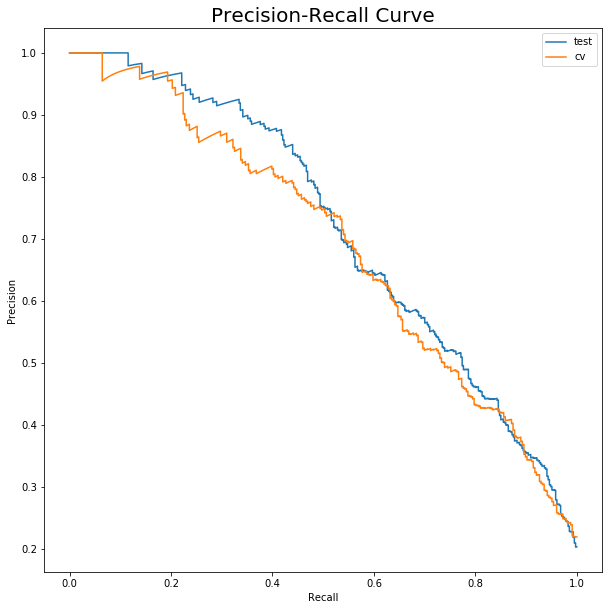

In [37]:
prepro_test_xgb_gscv = xgb_gscv.predict_proba(X_test)[:,1]
prepro_cv_xgb_gscv = xgb_gscv.predict_proba(X_cv)[:,1]

precision_xgb_gscv, recall_xgb_gscv, threshold_2_xgb_gscv = precision_recall_curve(y_test, prepro_test_xgb_gscv)
precision_1_xgb_gscv, recall_1_xgb_gscv, threshold_3_xgb_gscv = precision_recall_curve(y_cv, prepro_cv_xgb_gscv)

fig_1 = plt.figure(figsize=(10,10))
ax_1 = plt.subplot(111)
ax_1.plot(recall_xgb_gscv,precision_xgb_gscv, label="test")
ax_1.plot(recall_1_xgb_gscv,precision_1_xgb_gscv, label="cv")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

# Comparing Normal XgBoost Vs Randomized XgBoost Vs Grid XgBoost :-

In [38]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Test/Cv", "Accuracy(in %)", "ROC-AUC Score(in %)", "Precision Score(in %)", "Recall Score(in %)"]
x.add_row(["XGBoost (Normal)", "CV", accuracy_score(y_cv, cv_pred_xgb)*100, round(roc_auc_score(y_cv,prepro_cv_xgb)*100), round(precision_score(y_cv, cv_pred_xgb)*100), round(recall_score(y_cv, cv_pred_xgb)*100)])
x.add_row(["XGBoost (Normal)", "Test", accuracy_score(y_test, test_pred_xgb)*100, round(roc_auc_score(y_test,prepro_test_xgb)*100), round(precision_score(y_test, test_pred_xgb)*100), round(recall_score(y_test, test_pred_xgb)*100)])
x.add_row(["XGBoost (RandomizedSearchCv)", "CV", accuracy_score(y_cv, cv_pred_xgb_rscv)*100, round(roc_auc_score(y_cv,prepro_cv_xgb_rscv)*100), round(precision_score(y_cv, cv_pred_xgb_rscv)*100), round(recall_score(y_cv, cv_pred_xgb_rscv)*100)])
x.add_row(["XGBoost (RandomizedSearchCv)", "Test", accuracy_score(y_test, test_pred_xgb_rscv)*100, round(roc_auc_score(y_test,prepro_test_xgb_rscv)*100), round(precision_score(y_test, test_pred_xgb_rscv)*100), round(recall_score(y_test, test_pred_xgb_rscv)*100)])
x.add_row(["XGBoost (GridSearchCV)", "CV", accuracy_score(y_cv, cv_pred_xgb_gscv)*100, round(roc_auc_score(y_cv,prepro_cv_xgb_gscv)*100), round(precision_score(y_cv, cv_pred_xgb_gscv)*100), round(recall_score(y_cv, cv_pred_xgb_gscv)*100)])
x.add_row(["XGBoost (GridSearchCV)", "Test", accuracy_score(y_test, test_pred_xgb_gscv)*100, round(roc_auc_score(y_test,prepro_test_xgb_gscv)*100), round(precision_score(y_test, test_pred_xgb_gscv)*100), round(recall_score(y_test, test_pred_xgb_gscv)*100)])
print(x)

+------------------------------+---------+----------------+---------------------+-----------------------+--------------------+
|            Model             | Test/Cv | Accuracy(in %) | ROC-AUC Score(in %) | Precision Score(in %) | Recall Score(in %) |
+------------------------------+---------+----------------+---------------------+-----------------------+--------------------+
|       XGBoost (Normal)       |    CV   |     85.625     |         85.0        |          71.0         |        49.0        |
|       XGBoost (Normal)       |   Test  |      84.7      |         83.0        |          68.0         |        47.0        |
| XGBoost (RandomizedSearchCv) |    CV   |     85.625     |         86.0        |          80.0         |        39.0        |
| XGBoost (RandomizedSearchCv) |   Test  |      86.2      |         86.0        |          82.0         |        41.0        |
|    XGBoost (GridSearchCV)    |    CV   |     86.125     |         86.0        |          78.0         |      

![title](thank_you2.png "Header")